In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
#import pyDOE
from sepia.SepiaModelSetup import setup_model
from sepia.SepiaData import SepiaData
import sepia.SepiaPlot as SepiaPlot

In [3]:
import os
datadir = os.getcwd()+"/data/ball_drop_2/"
# experimental data
with open(datadir+'fieldDat15x6gparam.txt','r') as f:
    field_data = np.loadtxt(f)
with open(datadir+'desNative4x2Rrho.txt','r') as f:
    x = np.loadtxt(f) # x = {R, rho_ball}
x_obs = x

y_obs = [np.array(field_data[0:3,4]),np.array(field_data[3:6,4]),\
         np.array(field_data[6:12,4]),np.array(field_data[12:,4])]
h_obs = [np.array(field_data[0:3,3]),np.array(field_data[3:6,3]),\
         np.array(field_data[6:12,3]),np.array(field_data[12:,3])]# observed heights

# simulated data
with open(datadir+'desNative80x4Cg.txt','r') as f:
    sim_data = np.loadtxt(f)
x_sim = sim_data[:,0:2] # x = {R, rho_ball}
t_sim = sim_data[:,2:4] # t = {C, g}
with open(datadir+'simHeights101x1','r') as f:
    h_sim = np.loadtxt(f)
with open(datadir+'sims101x80Cg.txt','r') as f:
    y_sim = np.loadtxt(f).T

print(y_obs)
print(h_obs)
# create sepia data object
data = SepiaData(x_sim = x_sim, t_sim = t_sim, y_ind_sim = h_sim, y_sim = y_sim,\
                 x_obs = x, y_obs = y_obs, y_ind_obs = h_obs)

[array([2.2903015, 3.2610425, 4.3482492]), array([2.0149232, 2.7790069, 4.043753 ]), array([1.4650254, 1.9566485, 2.6335751, 2.7205137, 3.2327181, 3.5392515]), array([2.1502001, 3.1681314, 3.9311893])]
[array([20., 40., 60.]), array([20., 40., 60.]), array([10., 20., 30., 40., 50., 60.]), array([20., 40., 60.])]


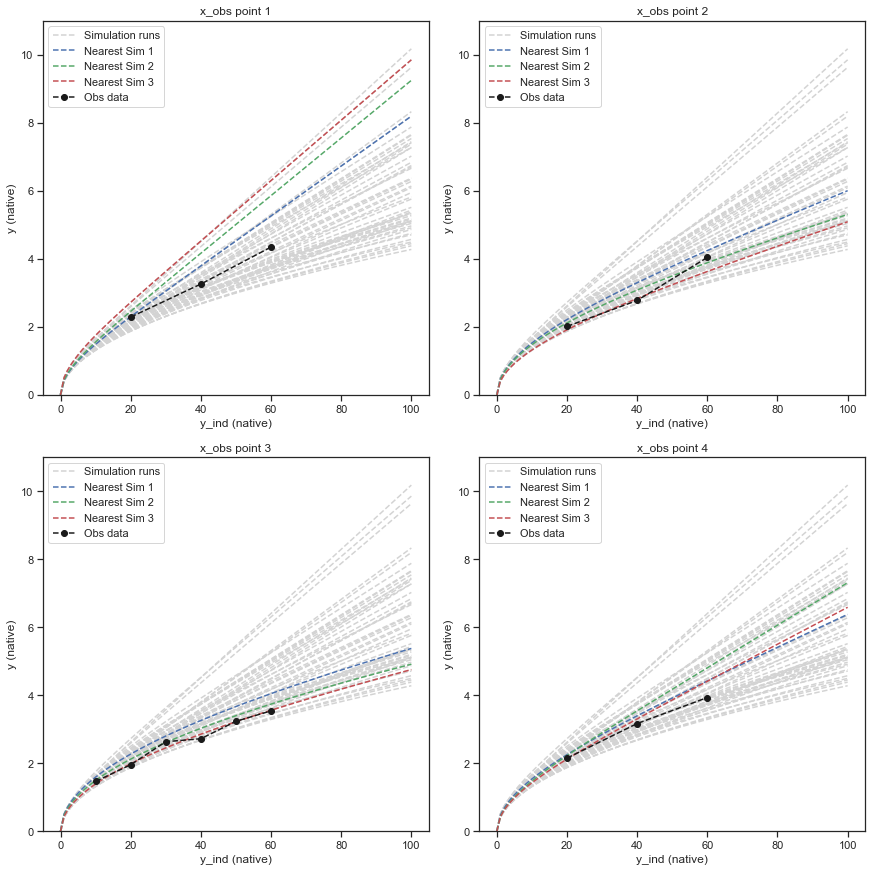

In [4]:
data.plot_data(x_min = -5, x_max = 105, y_min = 0, y_max = 11)

(Text(0, 0.5, 'C'), Text(0.5, 1.0, 'Simulation Design'))

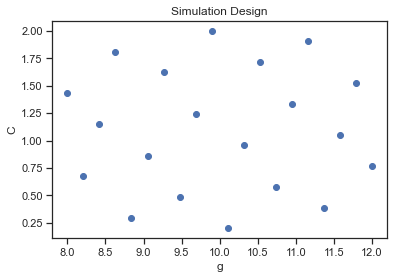

In [5]:
plt.scatter(t_sim[0:20,1],t_sim[0:20,0])
plt.xlabel("g");plt.ylabel("C"),plt.title("Simulation Design")

In [6]:
data.transform_xt()
data.standardize_y()

(5,)


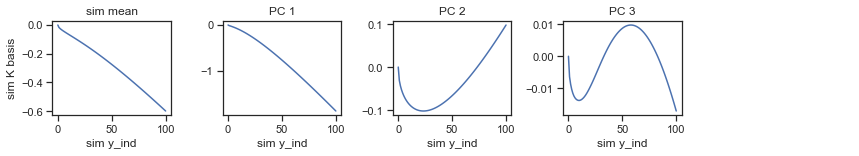

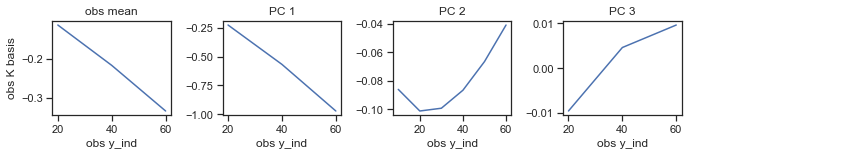

In [7]:
data.create_K_basis(3)
data.plot_K_basis()

In [8]:
data.create_D_basis('linear')
print(data)

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 101, obs y dimension ragged
n  =     4 (number of observed data)
m  =    80 (number of simulated data)
p  =     2 (number of inputs)
q  =     2 (number of additional simulation inputs to calibrate)
pu =     3 (transformed response dimension)
pv =     2 (transformed discrepancy dimension)



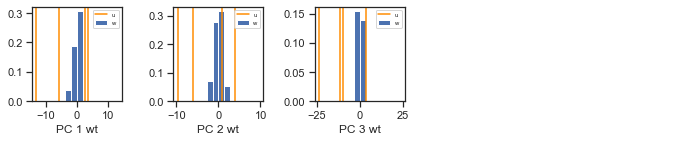

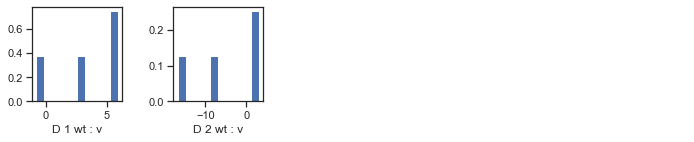

In [9]:
data.plot_K_weights()

Plotting up to 5 pairs. Change with parameter 'max_plots'


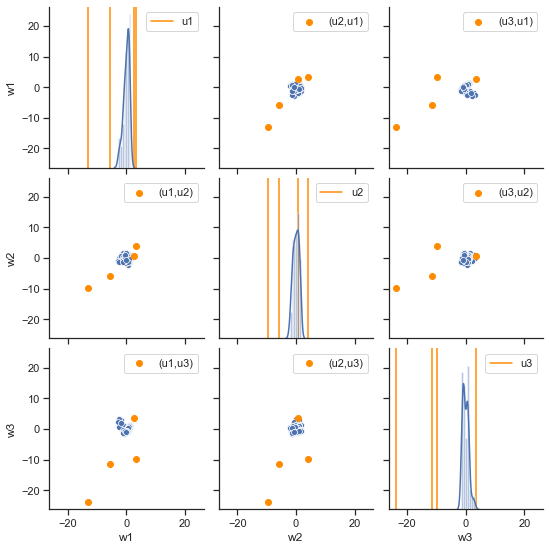

In [10]:
data.plot_u_w_pairs()

In [11]:
model = setup_model(data)
override=0
cachefile_name='ball_drop_2_ragged.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name) and override==0:
   model=pickle.load(open(cachefile_name, "rb" ))
else:
    model.tune_step_sizes(50, 20)
    model.do_mcmc(5000)
    pickle.dump(model, open( cachefile_name, "w+b" ))

Step size tuning:   0%|          | 0/50 [00:00<?, ?it/s]

lamWOs initialized outside default bounds [60, 1e5]; setting initial value to 1e5 - 1.
Starting tune_step_sizes...
Default step sizes:
theta
[[0.2 0.2]]
betaV
[[0.1]
 [0.1]]
betaU
[[0.1 0.1 0.1]
 [0.1 0.1 0.1]
 [0.1 0.1 0.1]
 [0.1 0.1 0.1]]
lamVz
[[10.]]
lamUz
[[5. 5. 5.]]
lamWs
[[100. 100. 100.]]
lamWOs
[[100.]]
lamOs
[[19.51419672]]


MCMC sampling:   0%|          | 0/5000 [00:00<?, ?it/s]

Done with tune_step_size.
Selected step sizes:
theta
[[0.21098338 0.56499282]]
betaV
[[0.82838104]
 [0.23073972]]
betaU
[[0.2082115  0.04426632 0.41288865]
 [0.50901356 0.08171261 0.56557421]
 [0.09610203 0.18667258 0.47070773]
 [0.04149099 0.1495863  0.02981301]]
lamVz
[[5893.46435349]]
lamUz
[[0.29430112 0.37625398 0.72427818]]
lamWs
[[14112.7686531  13047.53065778  5926.77581868]]
lamWOs
[[100.56832051]]
lamOs
[[149.82325814]]


MCMC sampling: 100%|██████████| 5000/5000 [01:34<00:00, 52.85it/s]


In [12]:
samples_dict = {p.name: p.mcmc_to_array(trim=1000,untransform_theta=True) for p in model.params.mcmcList}

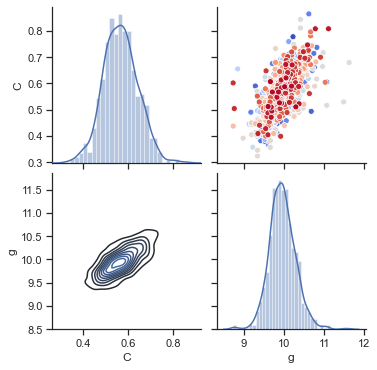

In [13]:
theta_names = ['C','g']
SepiaPlot.theta_pairs(samples_dict,theta_names)

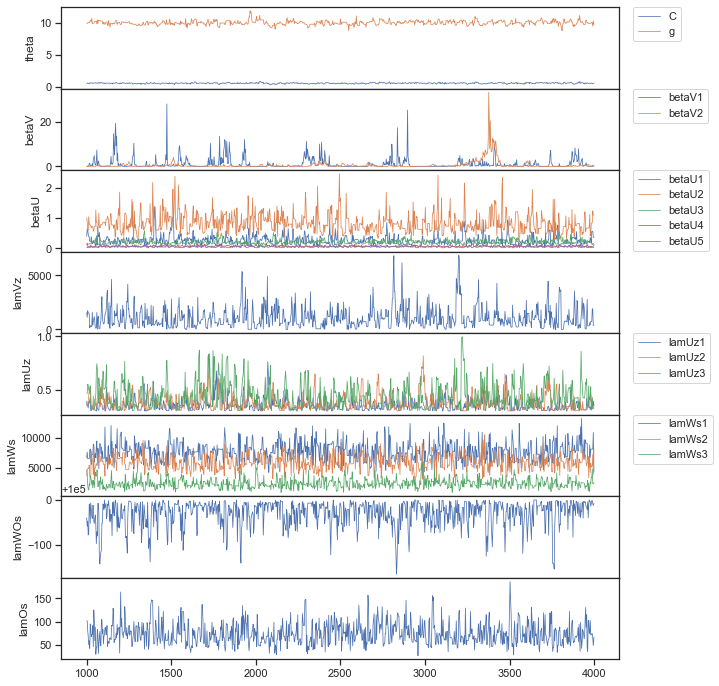

In [14]:
SepiaPlot.mcmc_trace(samples_dict,theta_names,start=1000,n_to_plot=1000,max_print=5)

In [15]:
p_stats = SepiaPlot.param_stats(samples_dict,theta_names,q1=.05,q2=.95,digits=4)
print(np.round(p_stats,4))

                mean         sd  0.05 quantile  0.95 quantile
C             0.5673     0.0765         0.4476         0.6910
g             9.9611     0.3242         9.4863        10.5169
betaV_1       0.9132     2.2336         0.0014         4.6488
betaV_2       0.5148     1.5948         0.0012         2.2154
betaU_1       0.2614     0.1466         0.0998         0.5440
betaU_2       0.8390     0.3137         0.4394         1.4181
betaU_3       0.2078     0.0651         0.1270         0.3347
betaU_4       0.0724     0.0204         0.0473         0.1106
betaU_5       0.0518     0.0276         0.0209         0.1028
betaU_6       0.1097     0.0564         0.0443         0.2179
betaU_7       0.9036     0.1867         0.6454         1.2590
betaU_8       0.3470     0.0836         0.2324         0.5075
betaU_9       0.6325     0.3349         0.2861         1.2266
betaU_10      0.8660     0.4761         0.3562         1.6799
betaU_11      2.7411     0.4969         2.0163         3.6574
betaU_12